Импортируем модули

In [1]:
import pandas as pd
import os
import json
import numpy as np

filepath = 'Google-Playstore.csv'

Объем памяти, который занимает файл на диске

In [2]:
def get_memory_stat_by_file(filepath):
    file_size = os.stat(filepath)
    print("File size = ", round(file_size.st_size / 1024**2, 2), 'Mb')

# 2a
get_memory_stat_by_file(filepath)

File size =  645.13 Mb


Объем памяти, который занимает набор данных при загрузке в память и вывод данных по колонкам с пометкой до оптимизации

In [3]:
def get_memory_stat_by_columns(dataset, condition):    
    memory_usage_stat = dataset.memory_usage(deep=True)    
    total_memory_usage = memory_usage_stat.sum()
    print(f"File \"{condition}\" in memory size =", round(total_memory_usage / 1024**2, 2), "Mb")

    columns = dataset.columns.to_list()    
    columns_stat_info = []

    for column in columns:
        column_info = {}
        column_info["Column name"] = column
        column_memory_usage = dataset[column].memory_usage(deep=True)
        column_info["Memory usage by column, Mb"] = round(column_memory_usage / 1024**2, 2)
        column_info["Memory percent, %"] = float(round(column_memory_usage / total_memory_usage * 100, 2))
        column_info["dtype"] = str(dataset.dtypes[column])
        columns_stat_info.append(column_info)
    
    columns_stat_info.sort(key = lambda x: x["Memory percent, %"], reverse=True)
    
    with open(f"lab_six_{condition}_result.json", 'w', encoding='utf-8') as file:
        json.dump(columns_stat_info, file, ensure_ascii=False, indent=4)

# 2b-3
initial_dataset = pd.read_csv(filepath, sep=',', encoding='utf-8')
get_memory_stat_by_columns(initial_dataset, 'not_optimized')

File "not_optimized" in memory size = 2217.89 Mb


Объем памяти, который занимает набор данных при загрузке в память после оптимизации и вывод данных по колонкам с пометкой после оптимизации

In [4]:
def get_modified_dataset(dataset):

    modified_dataset = pd.DataFrame()

    for column in dataset.columns:
        if (pd.api.types.is_object_dtype(dataset[column])):
            num_unique_values = len(dataset[column].unique())
            num_total_values = len(dataset[column])            
            if (num_unique_values / num_total_values < 0.5):
                modified_dataset.loc[:, column] = dataset[column].astype('category')
            else:
                modified_dataset.loc[:, column] = dataset[column]
        elif(pd.api.types.is_float_dtype(dataset[column])):
            modified_dataset.loc[:, column] = pd.to_numeric(dataset[column], downcast='float')
        elif(dataset[column].dtype == np.int64):
            modified_dataset.loc[:, column] = pd.to_numeric(dataset[column], downcast='unsigned')
        else:
            modified_dataset.loc[:, column] = dataset[column]
    
    return modified_dataset

# 4-7
modified_dataset = get_modified_dataset(initial_dataset)
get_memory_stat_by_columns(modified_dataset, 'optimized')

File "optimized" in memory size = 862.19 Mb


Выбор произвольных 10 колонок и сохранение полученного поднабора в отдельном файле

In [5]:
def get_columns_dtypes(modified_dataset):
    columns = ["App Name", "Category", "Rating", "Rating Count", "Installs", 
               "Maximum Installs", "Free", "Price", "Size", "In App Purchases"]
    columns_dtypes = dict()

    for column in columns:
        columns_dtypes[column] = str(modified_dataset[column].dtype)

    with open("lab_six_column_dtypes.json", mode='w', encoding='utf-8') as file:
        json.dump(columns_dtypes, file, ensure_ascii=False, indent=4)

    return columns, columns_dtypes

def get_optimized_subset(columns_names, dataset):
    dataset.to_csv("lab_six_optimized_subset.csv", sep=',', columns=columns_names, index=False, encoding='utf-8')

# 8
columns_names, dtypes = get_columns_dtypes(modified_dataset)
get_optimized_subset(columns_names, modified_dataset)

Построение графиков

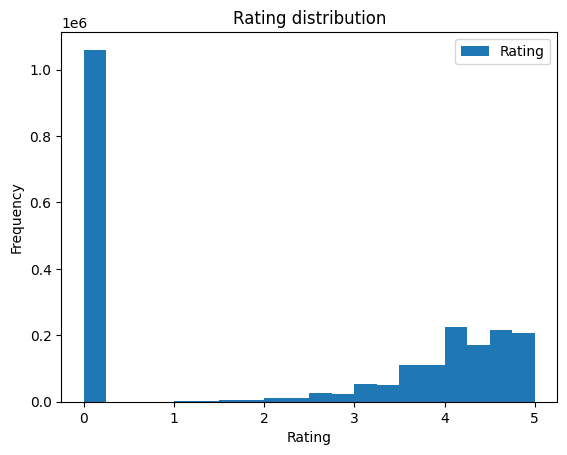

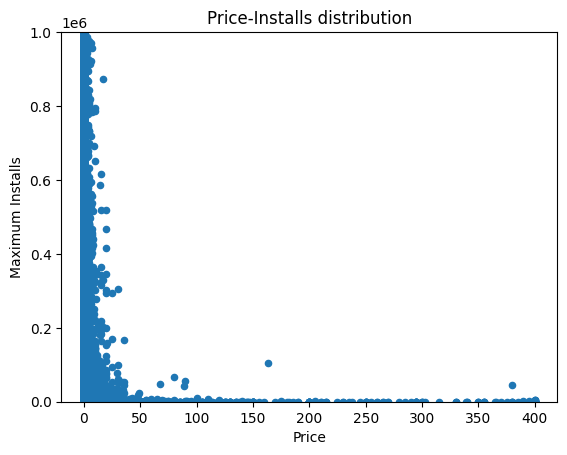

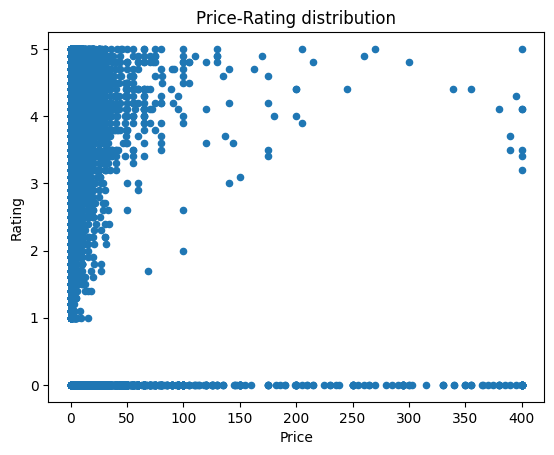

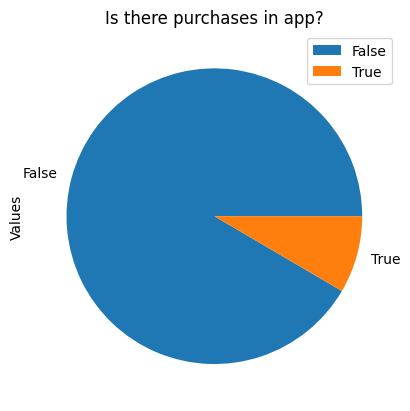

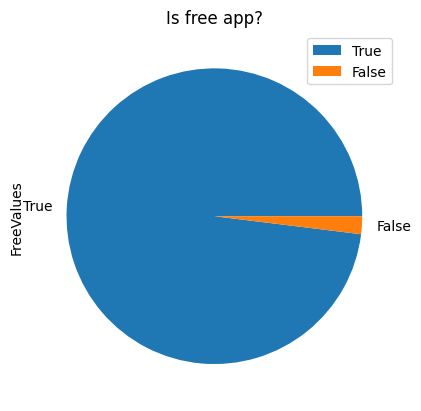

In [25]:
def get_plots(filepath, columns_names, dtypes):
    dataset = pd.read_csv(filepath, usecols=columns_names, dtype=dtypes)
    

    dataset.plot.hist(column=['Rating'], bins = 20, xlabel = 'Rating', title = 'Rating distribution')
    dataset.plot.scatter(x='Price', y='Maximum Installs', 
                         title = 'Price-Installs distribution', ylim = (0, 1e6))
    dataset.plot.scatter(x='Price', y='Rating', title = 'Price-Rating distribution')
    
    has_purchases_counts = dataset['In App Purchases'].value_counts()
    df = pd.DataFrame(data=has_purchases_counts.values, index=has_purchases_counts.index, columns=['Values'])
    df.plot.pie(y='Values', title = 'Is there purchases in app?')

    has_purchases_counts = dataset['Free'].value_counts()
    df = pd.DataFrame(data=has_purchases_counts.values, index=has_purchases_counts.index, columns=['FreeValues'])
    df.plot.pie(y='FreeValues', title = 'Is free app?')
    


# 9
get_plots(filepath, columns_names, dtypes)